## Visual EDA — Card Churn Dataset (No modeling)
This notebook focuses on visual understanding only, based on your CSVs:
- saldo_202510011329.csv
- account_202510011325.csv
- db_test_1_202510011326.csv (optional demographics)
- firebase_1_202510011328.csv, firebase_2_202510011328.csv (app activity)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("coolwarm")

# Load CSVs
saldo = pd.read_csv("saldo_202510011329.csv")
account = pd.read_csv("account_202510011325.csv")
fb1 = pd.read_csv("firebase_1_202510011328.csv")
fb2 = pd.read_csv("firebase_2_202510011328.csv")

# Types
saldo.columns = [c.lower() for c in saldo.columns]
saldo["v_date"] = pd.to_datetime(saldo["v_date"], errors="coerce", utc=True)
for fb in (fb1, fb2):
    fb.columns = [c.lower() for c in fb.columns]
    fb["event_date"] = pd.to_datetime(fb["event_date"], errors="coerce")

saldo.head(3)


,id,v_date,s_in,s_out,dt,ct,bs_in,bs_out,bct,date_next_oper,bdt
0,16309000290695381079,2025-01-06 00:00:00+00:00,-2742002,-3180722,438720,0,-2742002,-3180722,0,2025-01-09 00:00:00.000,438720
1,16309000990252775028,2025-01-06 00:00:00+00:00,-3419006,-3692526,273520,0,-3419006,-3692526,0,2025-01-07 00:00:00.000,273520
2,16377000290181563007,2025-01-06 00:00:00+00:00,0,-106370915,106370915,0,0,-106370915,0,3033-01-01 00:00:00.000,106370915


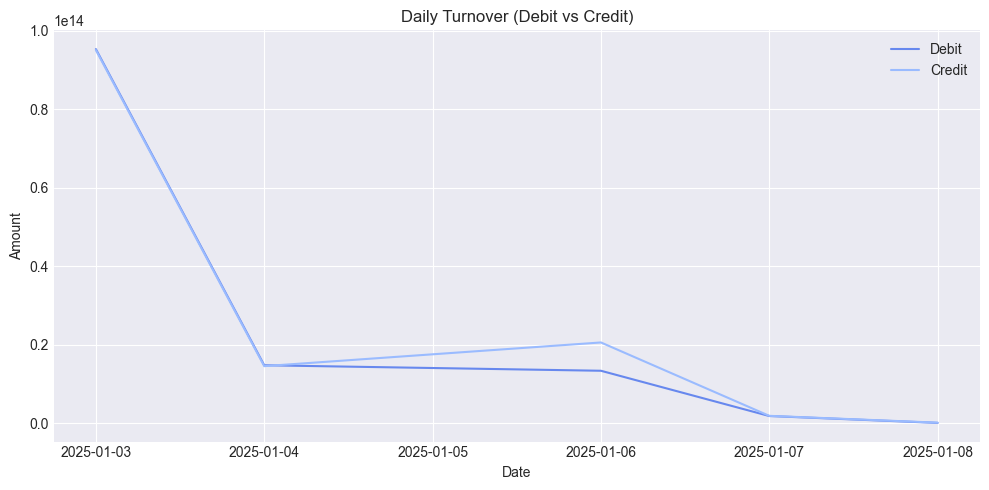

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=dt<br>v_date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'dt',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'dt',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2025-01-03T00:00:00.000000000', '2025-01-04T00:00:00.000000000',
                          '2025-01-06T00:00:00.000000000', '2025-01-07T00:00:00.000000000',
                          '2025-01-08T00:00:00.000000000'], dtype='datetime64[ns]'),
              'xaxis': 'x',
              'y': array([95366081819702, 14794634337600, 13393785987491,  1857586100802,
                            108507787802]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=ct<br>v_date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'ct',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'ct',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2025-01-03T00:00:00.000000000', '2025-01-04T00:00:00.000000000',
                          '2025-01-06T00:00:00.000000000', '2025-01-07T00:00:00.000000000',
                          '2025-01-08T00:00:00.000000000'], dtype='datetime64[ns]'),
              'xaxis': 'x',
              'y': array([95124654169574, 14568553805066, 20605492472876,  1906222743181,
                            169674892051]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Type'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Daily Turnover (Interactive)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'v_date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [4]:
# Daily debit/credit turnover
_daily = saldo.groupby('v_date')[['dt','ct']].sum().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=_daily, x='v_date', y='dt', label='Debit')
sns.lineplot(data=_daily, x='v_date', y='ct', label='Credit')
plt.title('Daily Turnover (Debit vs Credit)')
plt.xlabel('Date'); plt.ylabel('Amount')
plt.tight_layout(); plt.show()

# Optional interactive
fig = px.line(_daily, x='v_date', y=['dt','ct'], title='Daily Turnover (Interactive)')
fig.update_layout(legend_title_text='Type')
fig


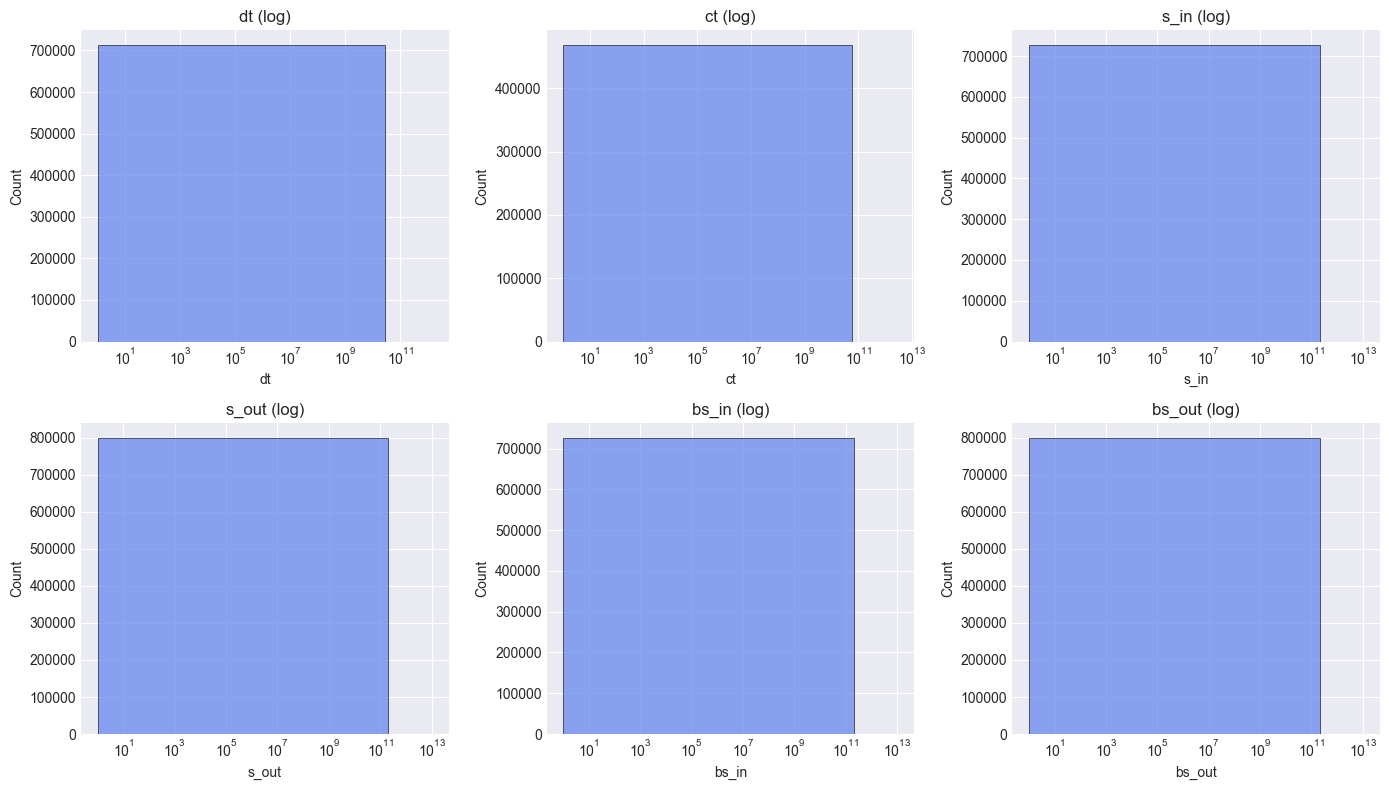

In [5]:
# Log distributions of amounts
cols = ['dt','ct','s_in','s_out','bs_in','bs_out']
fig, axes = plt.subplots(2,3, figsize=(14,8)); axes = axes.ravel()
for i,c in enumerate(cols):
    x = saldo[c].replace([np.inf,-np.inf], np.nan).dropna().abs()
    x = x[x>0]
    if x.empty:
        axes[i].text(0.5,0.5,f'No data: {c}', ha='center'); continue
    sns.histplot(x, bins=50, ax=axes[i])
    axes[i].set_xscale('log'); axes[i].set_title(f'{c} (log)')
plt.tight_layout(); plt.show()


"распределение сумм транзакций по каждому из выбранных столбцов в логарифмическом масштабе"

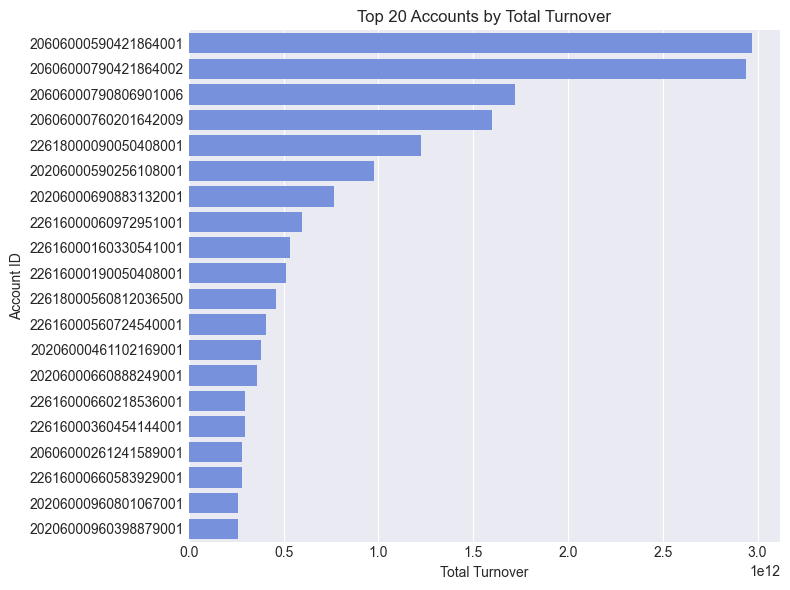

In [6]:
# Top accounts by total turnover (|dt|+|ct|)
turnover = saldo.groupby('id')[['dt','ct']].sum().abs().sum(axis=1).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=turnover.values, y=turnover.index)
plt.title('Top 20 Accounts by Total Turnover')
plt.xlabel('Total Turnover'); plt.ylabel('Account ID')
plt.tight_layout(); plt.show()


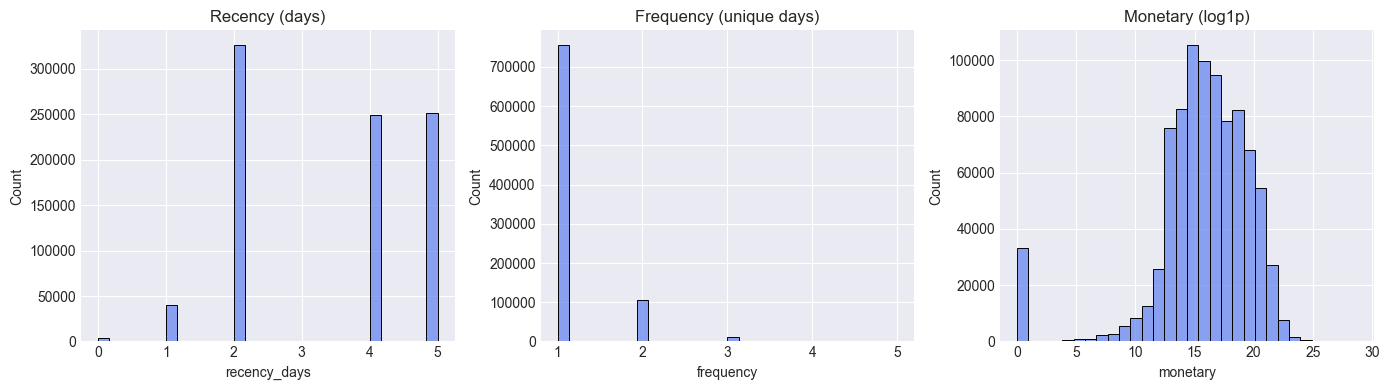

In [7]:
# Simple RFM (Recency, Frequency, Monetary) — descriptive only
s = saldo.copy()
s['date'] = s['v_date'].dt.tz_convert(None)
max_date = s['date'].max()

rfm = (
    s.groupby('id')
     .agg(
         recency_days=('date', lambda x: (max_date - x.max()).days),
         frequency=('date', 'nunique'),
         monetary=('dt', lambda x: x.fillna(0).abs().sum() + s.loc[x.index, 'ct'].fillna(0).abs().sum())
     )
     .reset_index()
)

fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.histplot(rfm['recency_days'], bins=30, ax=axes[0]); axes[0].set_title('Recency (days)')
sns.histplot(rfm['frequency'], bins=30, ax=axes[1]); axes[1].set_title('Frequency (unique days)')
sns.histplot(np.log1p(rfm['monetary']), bins=30, ax=axes[2]); axes[2].set_title('Monetary (log1p)')
plt.tight_layout(); plt.show()


"Давность, Частота, Денежный"

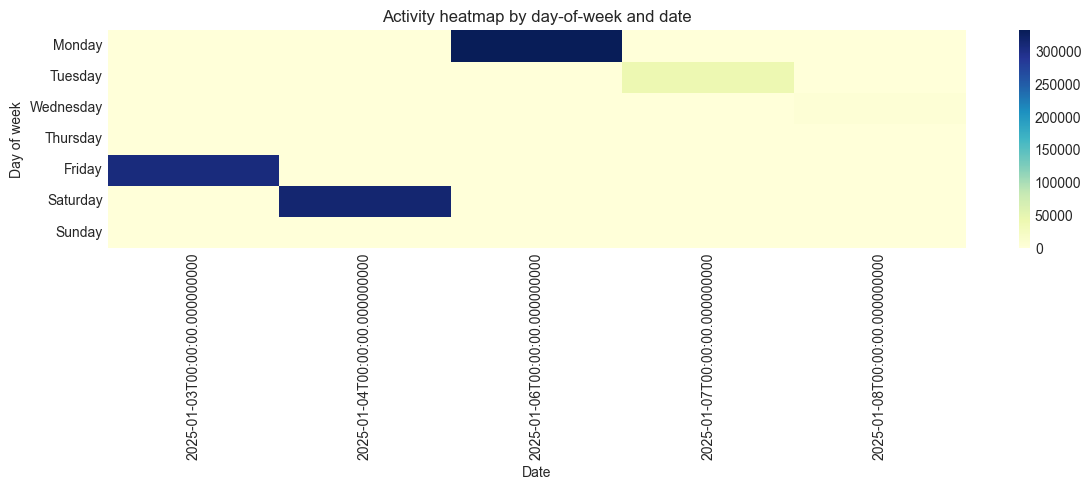

In [10]:
# Day-of-week heatmap of activity
s = saldo.copy()
s['date'] = s['v_date'].dt.tz_convert(None)
s['dow'] = s['date'].dt.day_name()

# Group by day-of-week and date
heat = s.groupby(['dow','date']).size().unstack(fill_value=0)

# Ensure all days are present in order
all_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heat = heat.reindex(all_days, fill_value=0)

# Plot heatmap
plt.figure(figsize=(12,5))
sns.heatmap(heat, cmap='YlGnBu')
plt.title('Activity heatmap by day-of-week and date')
plt.xlabel('Date')
plt.ylabel('Day of week')
plt.tight_layout()
plt.show()


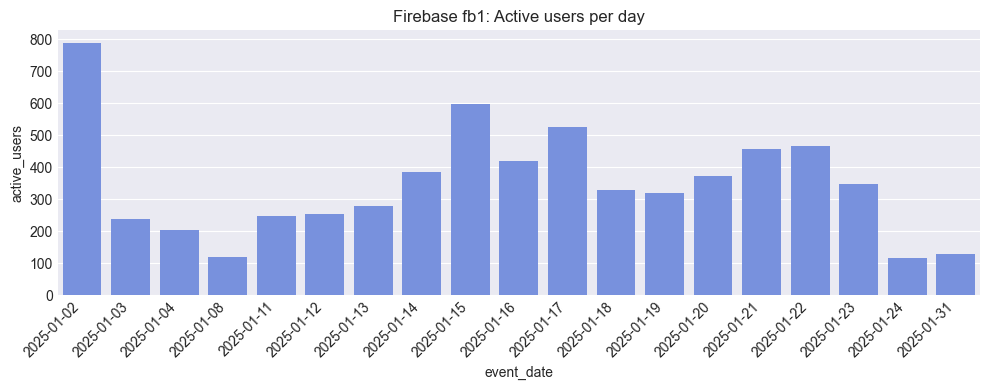

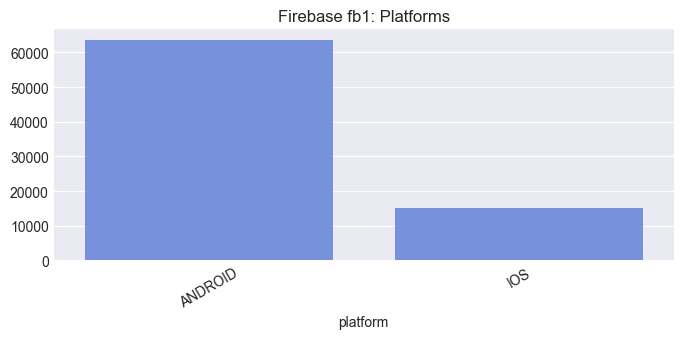

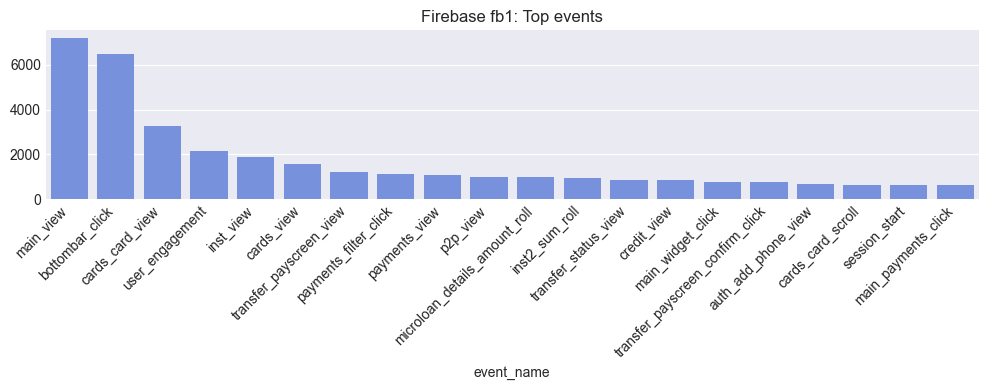

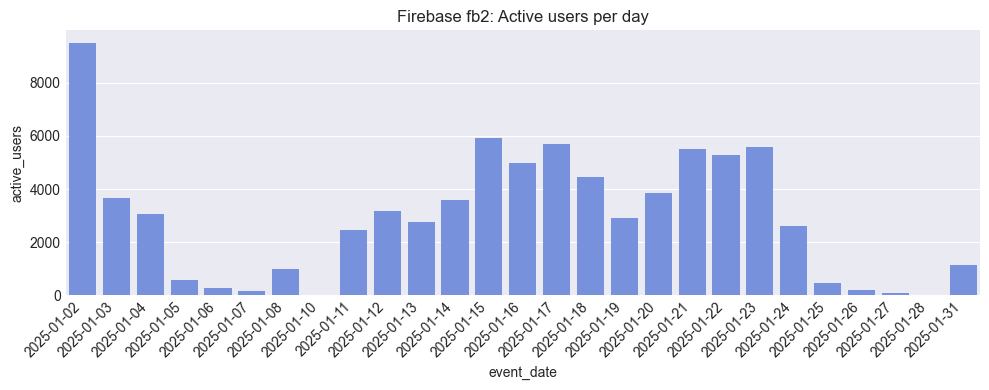

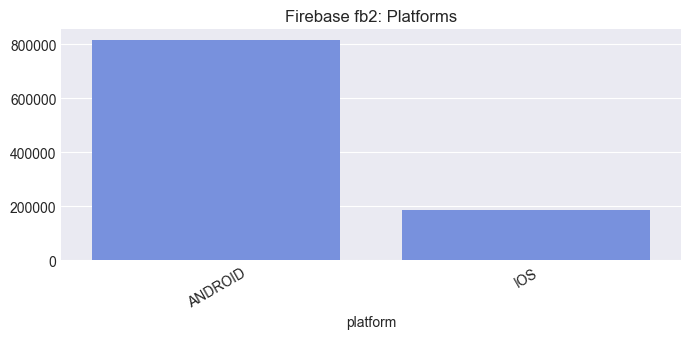

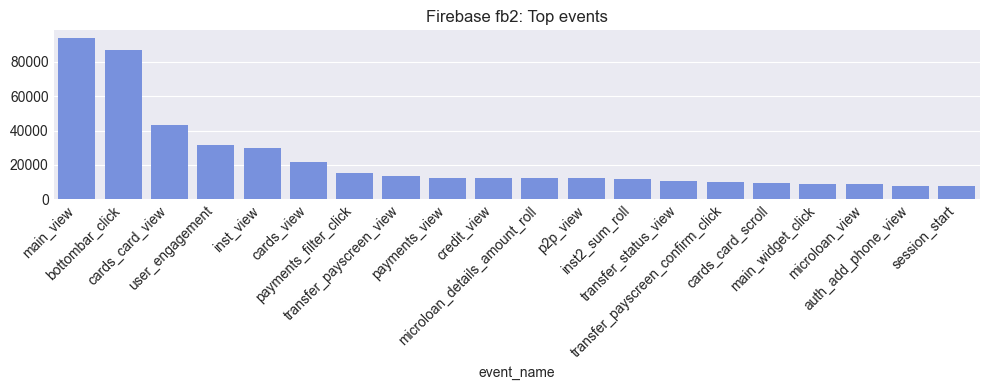

In [11]:
# Firebase active users per day and platform/event summaries

for fb, name in [(fb1, 'fb1'), (fb2, 'fb2')]:
    tmp = fb.dropna(subset=['event_date']).copy()
    daily_au = tmp.groupby(tmp['event_date'].dt.date)['id'].nunique().reset_index(name='active_users')
    plt.figure(figsize=(10,4))
    sns.barplot(data=daily_au, x='event_date', y='active_users')
    plt.title(f'Firebase {name}: Active users per day')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    plat = tmp['platform'].value_counts().head(10)
    events = tmp['event_name'].value_counts().head(20)

    plt.figure(figsize=(8,3))
    sns.barplot(x=plat.index, y=plat.values)
    plt.title(f'Firebase {name}: Platforms'); plt.xticks(rotation=30); plt.show()

    plt.figure(figsize=(10,4))
    sns.barplot(x=events.index, y=events.values)
    plt.title(f'Firebase {name}: Top events'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


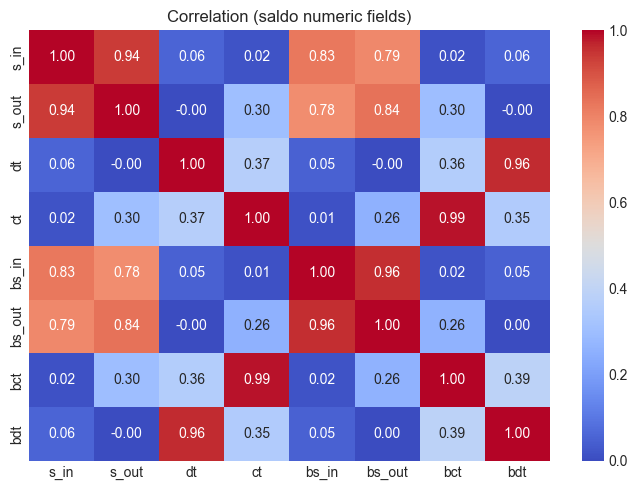

In [12]:
# Correlation heatmap for saldo numeric fields
num_cols = ['s_in','s_out','dt','ct','bs_in','bs_out','bct','bdt']
num_cols = [c for c in num_cols if c in saldo.columns]
plt.figure(figsize=(7,5))
sns.heatmap(saldo[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation (saldo numeric fields)')
plt.tight_layout(); plt.show()
